## Binary classification with EEGNet

The paths utilized are defiend in the `path_module.py`

Before this, the data must be processed. 
- `data_processing` notebook loads raw data and prepares training,validation and test dataset

### 1. Import libraries

In [1]:
from modules.path_module import *
from modules.utils_module import *
import os
import joblib
import torch
import numpy as np
import matplotlib.pyplot as plt

### 2. Load data

In [2]:
train_data=joblib.load(os.path.join(processed_datapath,"train_data.joblib"))
test_data=joblib.load(os.path.join(processed_datapath,"test_data.joblib"))
val_data=joblib.load(os.path.join(processed_datapath,"val_data.joblib"))

### 3. Prepare data
- We train using the training set and save the model that gives the best performance on the validation set

In [3]:
train_sigdata,train_label=prepare_cnn_data(train_data)
val_sigdata,val_label=prepare_cnn_data(val_data)
test_sigdata,test_label=prepare_cnn_data(test_data)

### 4. EEGNet model

Pytorch conversion from keras implementation https://github.com/vlawhern/arl-eegmodels/blob/master/EEGModels.py

Main repo: https://github.com/vlawhern/arl-eegmodels


In [4]:
import torch.nn as nn

class EEGNet(nn.Module):
    def __init__(self, nb_classes, Chans=59, Samples=2500, dropoutRate=0.5, kernLength=64, F1=8, D=2, F2=16, norm_rate=0.25, dropoutType='Dropout'):
        super(EEGNet, self).__init__()

        if dropoutType == 'SpatialDropout2D':
            self.DropoutType = nn.Dropout2d
        elif dropoutType == 'Dropout':
            self.DropoutType = nn.Dropout
        else:
            raise ValueError('dropoutType must be one of SpatialDropout2D or Dropout, passed as a string.')

        self.conv1 = nn.Conv2d(1, F1, (1, kernLength), padding='same', bias=False)
        self.batchnorm1 = nn.BatchNorm2d(F1)
        self.depthwise_conv = nn.Conv2d(F1, F1 * D, (Chans, 1), groups=F1, bias=False, padding='valid')
        self.batchnorm2 = nn.BatchNorm2d(F1 * D)
        self.elu1 = nn.ELU()
        self.avgpool1 = nn.AvgPool2d((1, 4))
        self.dropout1 = self.DropoutType(dropoutRate)
        
        self.separable_conv = nn.Sequential(
            nn.Conv2d(F1 * D, F1 * D, (1, 16), groups=F1 * D, bias=False, padding='same'),
            nn.Conv2d(F1 * D, F2, kernel_size=(1, 1), bias=False)
        )
        self.batchnorm3 = nn.BatchNorm2d(F2)
        self.elu2 = nn.ELU()
        self.avgpool2 = nn.AvgPool2d((1, 8))
        self.dropout2 = self.DropoutType(dropoutRate)
        
        self.flatten = nn.Flatten()
        self.dense = nn.Linear(F2 * (Samples // 32), nb_classes)
        
        
    def forward(self, x):
        x = x.unsqueeze(1)  # Add a channel dimension
        x = self.conv1(x)
        x = self.batchnorm1(x)
        
        x = self.depthwise_conv(x)
        x = self.batchnorm2(x)
        x = self.elu1(x)
        x = self.avgpool1(x)
        x = self.dropout1(x)
        
        x = self.separable_conv(x)
        x = self.batchnorm3(x)
        x = self.elu2(x)
        x = self.avgpool2(x)
        x = self.dropout2(x)
        
        x = self.flatten(x)
        x = self.dense(x)
        return x

### 5. Initialize model

In [5]:
import torch.optim as optim
from torch import cuda

# Set the random seed for reproducibility
random_seed = 42
random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
np.random.seed(random_seed)

# use GPU
device='cpu'#'cuda' if cuda.is_available() else 'cpu'
print("Running on: "+device)
cuda.empty_cache()

Fs=500 #sampling rate
# initialize model
n_chan=train_data[0].data.shape[1]
n_datalength=train_data[0].data.shape[0]
# Example usage
nb_classes = 2  # Number of classes
Chans = n_chan  # Number of channels
Samples = n_datalength  # Number of time points
dropoutRate = 0.5 # from original
#kernLength = Fs // 2 + 1
kernLength = 32 # from original
F1 = 8 # from original
D = 2 # from original
F2 = F1*D # from original
norm_rate = 0.25 # from original
dropoutType = 'Dropout' # from original

model = EEGNet(nb_classes, Chans, Samples, dropoutRate, kernLength, F1, D, F2, norm_rate, dropoutType)

model.to(device)
print('Model created')

Running on: cpu
Model created


### 6. Configure Training

In [6]:
#batch_size = 8#1
batch_size = 16 # from original
#num_epochs = 64
num_epochs = 300 # from original
# lrate=5e-3
lrate=0.001 # from original
patience=800 # no effective early stopping
#patience=80 
# Define loss function and optimizer
criterion = nn.BCELoss() # paper used categorial cross entropy for multi class
optimizer = optim.Adam(model.parameters(), lr=lrate) #from original
cnn_modelfullpath=os.path.join(cnn_modelpath,'eegnet.pt')
random_seed=42

training_arg={
    'modelfullpath': cnn_modelfullpath,
    'criterion': criterion,
    'optimizer': optimizer,
    'epochs': num_epochs,
    'patience': patience,
    'seed': random_seed
}

### 7. Prepare data

In [7]:
from torch.utils.data import DataLoader, TensorDataset

train_dataset = TensorDataset(torch.stack(train_sigdata), torch.stack(train_label))
val_dataset = TensorDataset(torch.stack(val_sigdata), torch.stack(val_label))
test_dataset = TensorDataset(torch.stack(test_sigdata), torch.stack(test_label))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

### 8. Train model

In [9]:
results= model_trainer(model,train_loader,val_loader,training_arg)

Epoch 1/300: 100%|██████████| 21/21 [00:03<00:00,  5.66it/s]


model state saved with validation accuracy: 51.4493


Epoch 5/300: 100%|██████████| 21/21 [00:03<00:00,  6.38it/s]


model state saved with validation accuracy: 52.1739


Epoch 6/300: 100%|██████████| 21/21 [00:03<00:00,  6.33it/s]


model state saved with validation accuracy: 57.2464


Epoch 7/300: 100%|██████████| 21/21 [00:03<00:00,  6.49it/s]


model state saved with validation accuracy: 60.1449


Epoch 9/300: 100%|██████████| 21/21 [00:04<00:00,  5.18it/s]


model state saved with validation accuracy: 64.4928


Epoch 10/300: 100%|██████████| 21/21 [00:03<00:00,  6.15it/s]


model state saved with validation accuracy: 68.1159


Epoch 11/300: 100%|██████████| 21/21 [00:03<00:00,  6.28it/s]


model state saved with validation accuracy: 71.7391


Epoch 15/300: 100%|██████████| 21/21 [00:03<00:00,  6.59it/s]


model state saved with validation accuracy: 72.4638


Epoch 19/300: 100%|██████████| 21/21 [00:03<00:00,  6.24it/s]


model state saved with validation accuracy: 77.5362


Epoch 24/300: 100%|██████████| 21/21 [00:03<00:00,  6.68it/s]


model state saved with validation accuracy: 78.9855


Epoch 28/300: 100%|██████████| 21/21 [00:03<00:00,  6.32it/s]


model state saved with validation accuracy: 80.4348


Epoch 44/300: 100%|██████████| 21/21 [00:03<00:00,  6.48it/s]


model state saved with validation accuracy: 83.3333


Epoch 64/300: 100%|██████████| 21/21 [00:03<00:00,  6.32it/s]


model state saved with validation accuracy: 84.0580


Epoch 83/300: 100%|██████████| 21/21 [00:03<00:00,  6.37it/s]


model state saved with validation accuracy: 85.5072


Epoch 86/300: 100%|██████████| 21/21 [00:03<00:00,  6.58it/s]


model state saved with validation accuracy: 86.2319


Epoch 89/300: 100%|██████████| 21/21 [00:03<00:00,  6.68it/s]


model state saved with validation accuracy: 86.9565


Epoch 105/300: 100%|██████████| 21/21 [00:03<00:00,  6.66it/s]


model state saved with validation accuracy: 87.6812


Epoch 116/300: 100%|██████████| 21/21 [00:03<00:00,  6.71it/s]


model state saved with validation accuracy: 88.4058


Epoch 160/300: 100%|██████████| 21/21 [00:03<00:00,  6.68it/s]


model state saved with validation accuracy: 89.1304


Epoch 175/300: 100%|██████████| 21/21 [00:03<00:00,  6.30it/s]


model state saved with validation accuracy: 91.3043


Epoch 275/300: 100%|██████████| 21/21 [00:03<00:00,  6.45it/s]


model state saved with validation accuracy: 93.4783


Epoch 285/300: 100%|██████████| 21/21 [00:03<00:00,  6.67it/s]


model state saved with validation accuracy: 94.2029


Epoch 300/300: 100%|██████████| 21/21 [00:03<00:00,  6.66it/s]


### 9. Inspect training process

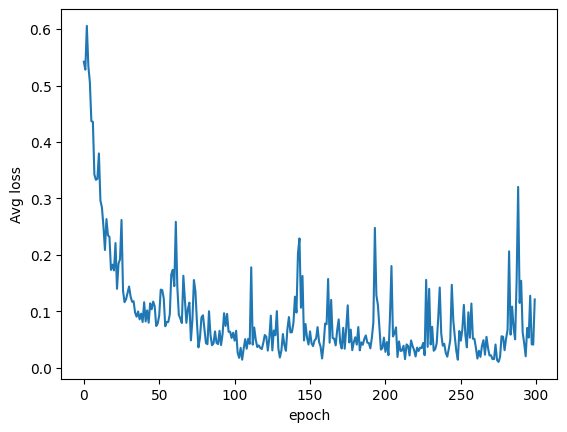

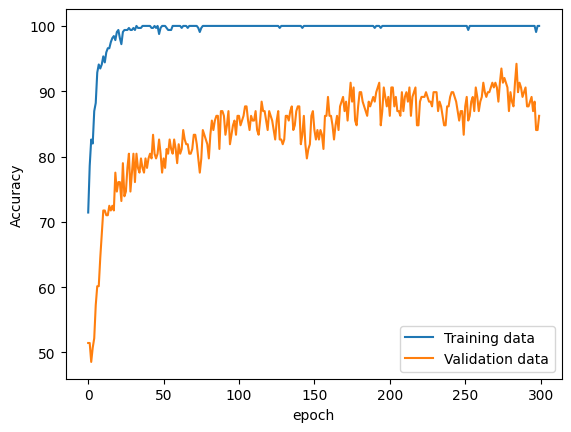

In [10]:
plt.figure()
plt.plot(results['epoch_loss'])
plt.xlabel('epoch')
plt.ylabel('Avg loss')
plt.show()


plt.figure()
plt.plot(results['training_acc'],label='Training data')
plt.plot(results['validation_acc'],label='Validation data')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()

### 10. Evaluate model

In [11]:
best_model_state=torch.load(cnn_modelfullpath, map_location=device)
model.load_state_dict(best_model_state,strict=True)
model.eval()
print('Fine tune model loaded')

tr_accuracy, tr_est,tr_labels,tr_scores= evaluate_binary_accuracy(model, train_loader)
print(f'Train Binary Accuracy: {tr_accuracy:.4f}')
perf_metrics(tr_labels, tr_est,tr_scores)
print('\n')
v_accuracy,val_est,val_labels, val_scores = evaluate_binary_accuracy(model, val_loader)
print(f'Validation Binary Accuracy: {v_accuracy:.4f}')
perf_metrics(val_labels, val_est,val_scores)
print('\n')
test_accuracy,test_est,test_labels, test_scores = evaluate_binary_accuracy(model, test_loader)
print(f'Test Binary Accuracy: {test_accuracy:.4f}')
perf_metrics(test_labels, test_est,test_scores)

print('Completed')

Fine tune model loaded
Train Binary Accuracy: 100.0000
Confusion Matrix:
[[168   0]
 [  0 154]]
Accuracy: 100.0
Precision: 100.0
Sensitivity (Recall): 100.0
Specificity: 100.0
F1 Score: 1.0
AUC Score: 1.0


Validation Binary Accuracy: 94.2029
Confusion Matrix:
[[67  5]
 [ 3 63]]
Accuracy: 94.20289855072464
Precision: 92.64705882352942
Sensitivity (Recall): 95.45454545454545
Specificity: 93.05555555555556
F1 Score: 0.9402985074626866
AUC Score: 0.9724326599326599


Test Binary Accuracy: 89.1304
Confusion Matrix:
[[43  5]
 [ 5 39]]
Accuracy: 89.13043478260869
Precision: 88.63636363636364
Sensitivity (Recall): 88.63636363636364
Specificity: 89.58333333333334
F1 Score: 0.8863636363636365
AUC Score: 0.9673295454545455
Completed
